In [ ]:
## visualisation of the cocept space for the final print (fig.2)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as clr

from scipy.spatial.distance import cosine
from scipy.special import softmax

from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

sns.set(style="white")
import cmcrameri.cm as cmc
import umap
import pickle

h:\z\.conda\envs\data\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
h:\z\.conda\envs\data\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
h:\z\.conda\envs\data\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def get_pairwise_similarity(data, pairs):
    out = []
    for x, y in pairs:
        if np.array_equal(data[x], data[y]):
            out.append(1)
        else:
            out.append(-1)
    return np.array(out)

In [3]:
v = 4.02
save_path = r"O:/projekter/PY000017_D/analysis/plots/%s/" %v
try:
    os.makedir(save_path)
except:
    pass

In [4]:
with open('O:/projekter/PY000017_D/analysis/tcav/sample_act/%s_decoder.identity/act.pkl' %v, "rb") as f:
    act = pickle.load(f)
with open('O:/projekter/PY000017_D/analysis/tcav/sample_meta/%s_decoder.identity/meta.pkl' %v, "rb") as f:
    meta = pickle.load(f)  
    meta["prb"] = softmax(meta["predictions"], -1)[:,1]
    
ppl = pd.read_csv("K://22SSI/Germans/processed/populations/survival/population/result.csv").set_index("PERSON_ID")
ppl = ppl[ppl.index.isin(meta["sequence_ids"])]

ppl["EVENT_FINAL_DATE"] = pd.to_datetime(ppl["EVENT_FINAL_DATE"], format="%Y-%m-%d")
ppl["BIRTHDAY"] = pd.to_datetime(ppl["BIRTHDAY"], format="%Y-%m-%d")
ppl["UNLABELED"] = ppl.apply(lambda x: (x["TARGET"] == 0) & (x["EVENT_FINAL_DATE"] < pd.to_datetime("2020-12-31", format="%Y-%m-%d")), axis = 1)
trgs = np.array(meta["targets"]).reshape(-1)
unlb = np.isin(meta["sequence_ids"], ppl[ppl["UNLABELED"]].index.values)

In [5]:
### specify CMAP
_cmap = cmc.bamako
cmap = clr.LinearSegmentedColormap.from_list("bamako", [_cmap(225), _cmap(125), _cmap(50)], N=100)

_cmap = cmc.lajolla
cmap_u = clr.LinearSegmentedColormap.from_list("lajolla", [_cmap(225), _cmap(150), _cmap(75)], N=100)

In [6]:
### Uncertainty estimates
#trgs = np.array(meta["targets"]).reshape(-1) # targets
#unlb = np.isin(meta["sequence_ids"], ppl[ppl["UNLABELED"]].index.values) # binary variable to specify unlabeled
probs =  meta["prb"].reshape(-1) # predicted probabilities of the early mortality 
N = probs.shape[0]
theta = 0.823
risk  = 0.088

kappa, certain = np.zeros(N), np.zeros(N)
for i in range(kappa.shape[0]):
    if probs[i] > 0.5:
        kappa[i] = probs[i]
    else:
        kappa[i] = 1 - probs[i]
    certain[i] = (kappa[i] < theta)

In [7]:
def check_if_in_box(x,y, region):
    if (region[0] <= x <= region[1]) & (region[2] <= y <= region[3]): return  True
    return False

In [8]:
def insert_subplot(ax, region, box, c, s=70, linewidths=0.5, alpha=0.7, offset=0.1, cmap=None, edgecolor="white", marker="o" ):
    # Create inset axes for region A.
    ax_inset = ax.inset_axes(box)  # These are figure coordinates.
    mask = np.array([check_if_in_box(x, y, region) for x, y in zip(x_coords, y_coords)])
    if isinstance(s, np.ndarray): s = s[mask]
    if isinstance(alpha, np.ndarray): alpha = alpha[mask]
    if isinstance(linewidths, np.ndarray): linewidths = linewidths[mask]
    if isinstance(edgecolor, np.ndarray): edgecolor = edgecolor[mask]
    if isinstance(marker, np.ndarray): marker = marker[mask]
    if isinstance(c, np.ndarray): c = c[mask]
    ax_inset.scatter(x_coords[mask], y_coords[mask], s=s, c=c, edgecolors=edgecolor, linewidths=linewidths, alpha=alpha, cmap=cmap, marker=marker)
    ax_inset.set_xlim(region[0], region[1])
    ax_inset.set_ylim(region[2], region[3])
    # Connector Settings
    ax.indicate_inset_zoom(ax_inset,
                       edgecolor="black",
                       linestyle= (0,(0,0,1,1)),  
                       linewidth=1.5,   
                       )
    # Labels and Axis
    for spine in ax_inset.spines.values():
        spine.set_linestyle((0,(0,0,2,2.5))) 
        spine.set_visible(True)
    ax_inset.set_xticklabels([])
    ax_inset.set_yticklabels([])
    ax_inset.tick_params(axis='both', which='both', length=0)

In [9]:
## nature viz
TIME_STEPS= 4
COORDS = np.zeros([act.shape[0], 2, TIME_STEPS])
COORDS[:,0,0] = 5
COORDS[:,1,0] = 10

param = dict(n_components=2,
             min_dist=0.3, 
             n_neighbors = 50,
             densmap=True,
             dens_lambda=0.8, 
             metric="euclidean", 
             random_state=0, 
             init="spectral")

prj = umap.UMAP(**param)
xp = prj.fit_transform(act)
xm = xp
x_scaler =  MinMaxScaler(feature_range=(0,10))
y_scaler =  MinMaxScaler(feature_range=(0,20))
xm[:,0] = x_scaler.fit_transform(xp[:,0].reshape(-1,1)).reshape(-1)
xm[:,1] = y_scaler.fit_transform(xp[:,1].reshape(-1,1)).reshape(-1)
COORDS[:,:,-1] = xm

for i in range(1, TIME_STEPS-1):
    param = dict(n_components=2,
             min_dist=0.3, 
             n_neighbors = 50,
             densmap=True,
             dens_lambda=0.8, 
             metric="euclidean", 
             random_state=0, n_epochs=i*5,
             init="spectral")
    xr = umap.UMAP(**param).fit_transform(act)
    xr[:,0] = x_scaler.transform(xr[:,0].reshape(-1,1)).reshape(-1)
    xr[:,1] = y_scaler.transform(xr[:,1].reshape(-1,1)).reshape(-1)
    COORDS [:,:,i] = xr

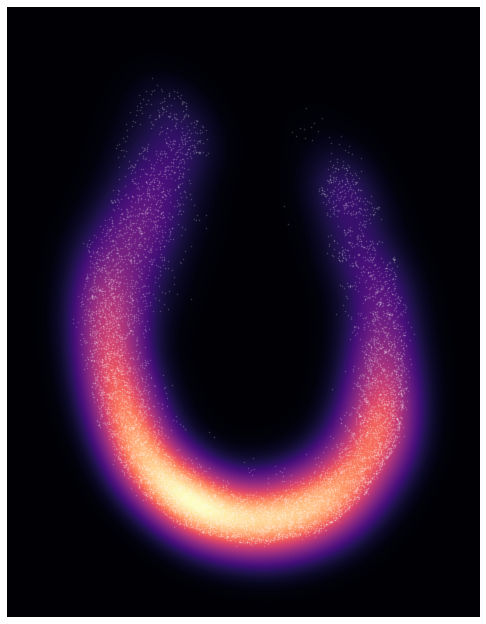

In [11]:
#ratio = 1.333
#fig, ax = plt.subplots(1, figsize=(10,10 * ratio))
from scipy.interpolate import interp1d
max_width_in_mm = 215
max_width_in_inches = max_width_in_mm / 25.4
max_height_in_mm = 285
max_height_in_inch = max_height_in_mm / 25.4
fig, ax = plt.subplots(1, figsize = (max_width_in_inches, max_height_in_inch))
ax.set_xlim([0, 10])
ax.set_ylim([-3, 23])
cmap_name="magma"
cmap_cp = "magma"
#cmap_cp = cmc.batlowK
ax = sns.kdeplot( x=xm[:,0], y=xm[:,1], fill=True, thresh=0, levels=200, cmap=cmap_cp)
#ax = sns.histplot( x=xm[:,0], y=xm[:,1], stat="density", cmap="mako")
ax.scatter(x= xm[:,0], y=xm[:,1], s=0.55, color="white", alpha=0.15)
from scipy.interpolate import interp1d
time_steps = np.arange(len(COORDS[0][0]))
time_steps_new = [0, 0.5, 1.2, 1.8, 2.3, 2.7, 3]#np.linspace(0, time_steps.max(), 7) 
num_segments = len(time_steps_new) - 1

for i in range(xm.shape[0]):
    x_coords = COORDS[i][0]
    y_coords = COORDS[i][1]
    # Interpolating    
    f_x = interp1d(time_steps, x_coords, kind='cubic')      
    f_y = interp1d(time_steps, y_coords, kind='cubic')

    x_smooth = f_x(time_steps_new)
    y_smooth = f_y(time_steps_new)

    for i in range(1, num_segments):
        if i > 2:
            alpha =  i * 1.2 / 100
        else:
            alpha = 0.001
        ax.plot(x_smooth[i:i+2], y_smooth[i:i+2], alpha=alpha, linewidth=0.05, color="white")

plt.autoscale()
plt.axis("off")
plt.savefig(save_path + "cover_%s.svg" %cmap_name, format="svg", backend="svg", bbox_inches="tight", pad_inches=0.01, transparent=True)
plt.show()

### Manuscript vizset_facecolor

In [9]:
param = dict(n_components=2,
             min_dist=0.3, 
             n_neighbors = 50,
             densmap=True,
             dens_lambda=0.8, 
             metric="euclidean", 
             random_state=0, 
             init="spectral")

prj = umap.UMAP(**param)
xp = prj.fit_transform(act)

In [10]:
xp[:,0] = MinMaxScaler(feature_range=(0,10)).fit_transform(xp[:,0].reshape(-1,1)).reshape(-1)
xp[:,1] = MinMaxScaler(feature_range=(0,20)).fit_transform(xp[:,1].reshape(-1,1)).reshape(-1)

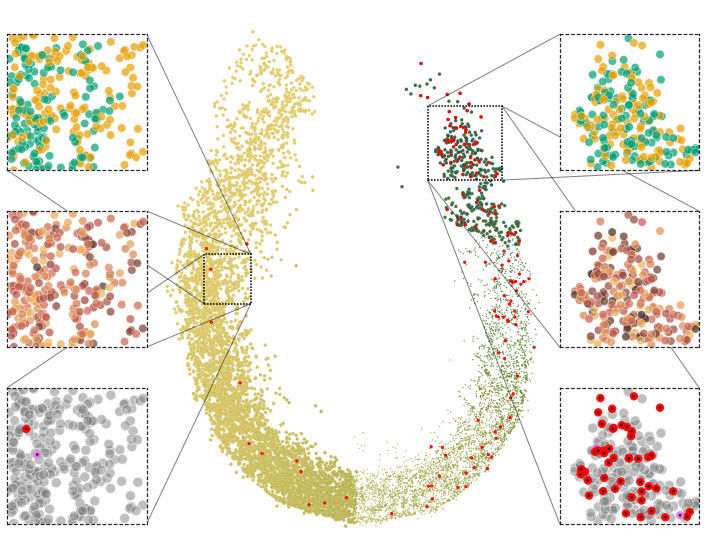

In [11]:
scaler = 1
_xp = xp[:,0] * scaler
x_coords = xp[:,0] * scaler
y_coords = xp[:,1]
_trgs = np.array(trgs).astype(bool)
region_a = (1 * scaler, 2.25 * scaler, 9,11)
region_b = (7 * scaler, 9 * scaler, 14,17)

fig, ax = plt.subplots(figsize=(10,10))

### 1. PLOT UNCERTAIN POINTS
mask = np.array(certain).astype(bool) # only keep uncertain predictions
ax.scatter(x_coords[mask], y_coords[mask], linewidth = 0.01, s=2, 
            edgecolors = "white", facecolors=cmap(probs[mask]), alpha=0.75, marker="o")
### 2. PLOT CERTAIN POINTS
mask = ~mask
plt.scatter(x_coords[mask], y_coords[mask], c=cmap(probs[mask]),  s= 12,  label = "Certain Predictions", edgecolor="white", linewidth=0.1, alpha=0.9)
### 3. PLOT TRUE DECEASED
ax.scatter(x_coords[_trgs], y_coords[_trgs], c= cmap(probs[_trgs]), edgecolor="red", s=1.5, linewidth=2, marker="o")


### A1. Plot region A with sex
_meta = np.array(meta["metadata"][:,2]).reshape(-1)
c = list()
for i in _meta:
    if i == 10:
        c.append("#e69f00")
    else:
        c.append("#009E73")
        
box_a1 = (-0.12,0.7,0.25,0.25)
insert_subplot(ax, region_a, box_a1, c = np.array(c))

### A2. Plot region A with age
_meta = np.array(meta["metadata"][:,4:5]).reshape(-1)
c = (_meta- 31)/30
box_a2 = (-0.12,0.375,0.25,0.25)
insert_subplot(ax, region_a, box_a2, c = np.array(c), cmap=cmap_u)

### A3. Plot region A with labels
c, a, s, lw, m,e = list(), list(), list(), list(), list(), list()
x_coords, y_coords = list(), list()
for i, (t, u) in enumerate(zip(trgs, unlb)):
    if ((t==0) & (u==0)):
        c.append("gray")
        e.append("white")
        a.append(0.5)
        s.append(100)
        lw.append(1.)
        m.append(".")
        x_coords.append(_xp[i])
        y_coords.append(xp[i,1])
for i, (t, u) in enumerate(zip(trgs, unlb)):
    if ((t==0) & (u==0)):
        continue
    elif ((t==1)):
        c.append("black")
        e.append("red")
        a.append(0.9)
        s.append(30)
        lw.append(3.)
        m.append("D")   
        x_coords.append(_xp[i])
        y_coords.append(xp[i,1])
    elif ((t==0) & (u==1)):
        c.append("black")
        e.append("violet")
        a.append(0.9)
        s.append(30)
        lw.append(3.)
        m.append("D")      
        x_coords.append(_xp[i])
        y_coords.append(xp[i,1])
        
box_a3 = (-0.12,0.05,0.25,0.25)
x_coords = np.array(x_coords)
y_coords = np.array(y_coords)
insert_subplot(ax, region_a, box_a3,  s=np.array(s), c = np.array(c), linewidths=np.array(lw), alpha=np.array(a), edgecolor=np.array(e))
            
### B1. Plot region B with sex
_meta = np.array(meta["metadata"][:,2]).reshape(-1)
c = list()
for i in _meta:
    if i == 10:
        c.append("#e69f00") # orange
    else:
        c.append("#009E73")
        
box_b1 = (0.87,0.7,0.25,0.25)
insert_subplot(ax, region_b, box_b1, c = np.array(c))

### B2. Plot region B with age
_meta = np.array(meta["metadata"][:,4:5]).reshape(-1)
c = (_meta- 31)/30
box_b2 = (0.87,0.375,0.25,0.25)
insert_subplot(ax, region_b, box_b2, c = np.array(c), cmap=cmap_u)

### A3. Plot region A with labels
c, a, s, lw, m,e = list(), list(), list(), list(), list(), list()
x_coords, y_coords = list(), list()
for i, (t, u) in enumerate(zip(trgs, unlb)):
    if ((t==0) & (u==0)):
        c.append("gray")
        e.append("white")
        a.append(0.5)
        s.append(100)
        lw.append(1.)
        m.append("o")
        x_coords.append(_xp[i])
        y_coords.append(xp[i,1])
for i, (t, u) in enumerate(zip(trgs, unlb)):
    if ((t==0) & (u==0)):
        continue
    elif ((t==1)):
        c.append("black")
        e.append("red")
        a.append(0.9)
        s.append(30)
        lw.append(3.)
        m.append("D")   
        x_coords.append(_xp[i])
        y_coords.append(xp[i,1])
    elif ((t==0) & (u==1)):
        c.append("black")
        e.append("violet")
        a.append(0.9)
        s.append(30)
        lw.append(3.)
        m.append("D")      
        x_coords.append(_xp[i])
        y_coords.append(xp[i,1])
        
box_b3 = (0.87,0.05,0.25,0.25)
x_coords = np.array(x_coords)
y_coords = np.array(y_coords)
insert_subplot(ax, region_b, box_b3, s=np.array(s), c = np.array(c), linewidths=np.array(lw), alpha=np.array(a),edgecolor=np.array(e))

#plt.tight_layout()
#plt.axis("tight")
plt.autoscale()
plt.axis("off")
plt.savefig(save_path + "summary_space.pdf", format="pdf")
plt.show()

In [46]:
np.random.seed(1)
data_file = pd.DataFrame({"x": xp[:,0],
                          "y": xp[:,1],
                          "sex": ["M" if i == 10 else "F" for i in np.array(meta["metadata"][:,2]).reshape(-1)],
                          "age": np.array(meta["metadata"][:,4:5]).reshape(-1).astype(int),
                          "deceased": np.array(meta["targets"]).astype(bool),
                          "unlabeled": unlb.reshape(-1).astype(bool),
                          "pred_probability": probs,
                          "pred_certainty": ~certain.astype(bool)}).sample(frac=1).reset_index(drop=True)


In [47]:
region_a = (1 * scaler, 2.25 * scaler, 9,11)
region_b = (7 * scaler, 9 * scaler, 14,17)

condition = ~((region_a[0] < data_file["x"]) & (data_file["x"]< region_a[1]) & (region_a[2] < data_file["y"]) & (data_file["y"]< region_a[3]) | 
(region_b[0] < data_file["x"]) & (data_file["x"]< region_b[1]) & (region_b[2] < data_file["y"]) & (data_file["y"]< region_b[3]))
data_file["sex"][condition] = "n/a"
data_file["age"][condition] = 0
data_file.to_csv(save_path + "person_summaries.csv")

C:\Users\X90\AppData\Local\Temp\59/ipykernel_146176/4261969798.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_file["sex"][condition] = "n/a"
C:\Users\X90\AppData\Local\Temp\59/ipykernel_146176/4261969798.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_file["age"][condition] = 0


In [48]:
data_file.head()

,x,y,sex,age,deceased,unlabeled,pred_probability,pred_certainty
0,7.434290,0.707846,n/a,0,False,False,0.265741,False
1,1.109957,11.128862,n/a,0,False,False,0.030922,True
2,9.684071,10.349532,n/a,0,False,False,0.785210,False
3,2.866303,2.695964,n/a,0,False,False,0.108660,True
4,8.626212,8.401789,n/a,0,False,False,0.635435,False


In [15]:
data_file.to_csv(save_path + "person_summaries.csv")